In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [128]:
# Load the dataset
loan_data = pd.read_csv('../data/loan.csv')

In [45]:
# Check for missing values
print(loan_data.isnull().sum())

loanId                                 256
anon_ssn                                 0
apr                                   3922
applicationDate                          0
originated                               0
originatedDate                      531638
nPaidOff                                24
approved                                 0
isFunded                                 0
loanStatus                               0
loanAmount                            2250
originallyScheduledPaymentAmount         0
state                                  132
leadCost                                 0
clarityFraudId                      219989
hasCF                                    0
fpStatus_Checked                         0
fpStatus_No Payments                     0
fpStatus_No Schedule                     0
fpStatus_Pending                         0
fpStatus_Rejected                        0
fpStatus_Returned                        0
fpStatus_Skipped                         0
leadType_ca

In [9]:
# Basic statistical overview of numerical columns
print(loan_data.describe())

                 apr       nPaidOff       isFunded     loanAmount  \
count  573760.000000  577658.000000  577682.000000  575432.000000   
mean      553.080972       0.037887       0.067480     514.245084   
std       110.046159       0.333366       0.250852     320.939929   
min         0.000000       0.000000       0.000000       0.000000   
25%       490.000000       0.000000       0.000000     350.000000   
50%       590.000000       0.000000       0.000000     500.000000   
75%       601.000000       0.000000       0.000000     500.000000   
max       705.590000      21.000000       1.000000    5000.000000   

       originallyScheduledPaymentAmount       leadCost          hasCF  
count                     577682.000000  577682.000000  577682.000000  
mean                        1428.897209       7.854389       0.619187  
std                          925.009141      12.853451       0.485587  
min                         -816.710000       0.000000       0.000000  
25%               

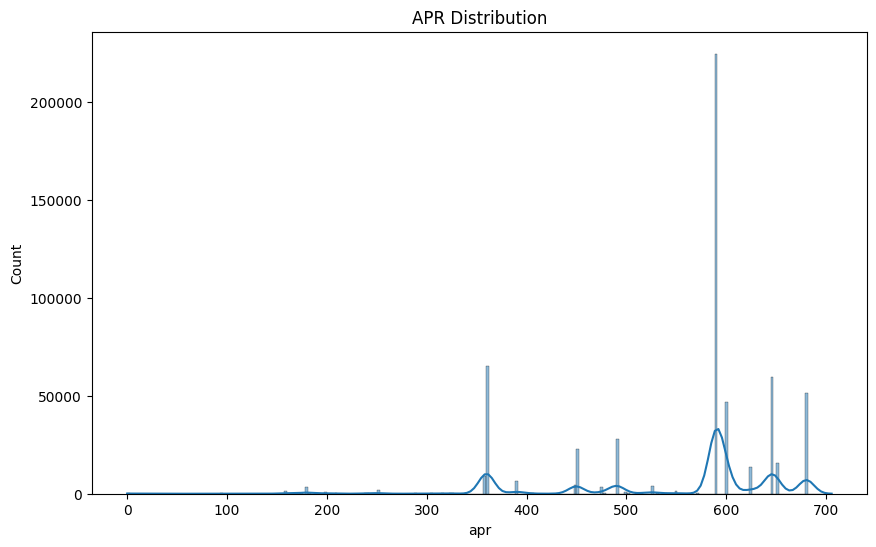

In [10]:
# Visualizing distribution of APR
plt.figure(figsize=(10, 6))
sns.histplot(loan_data['apr'], kde=True)
plt.title('APR Distribution')
plt.show()

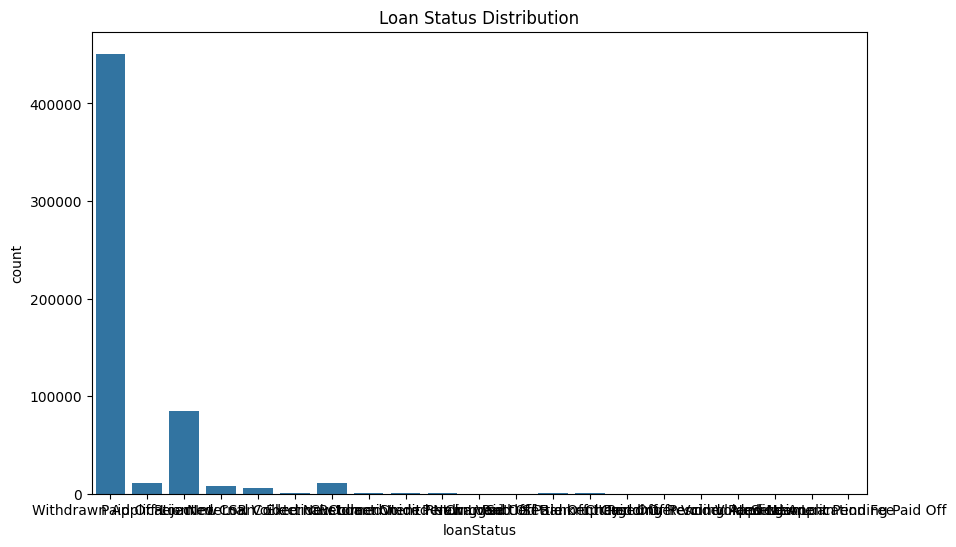

In [14]:
# Visualizing the loanStatus counts
plt.figure(figsize=(10, 6))
sns.countplot(data=loan_data, x='loanStatus')
plt.title('Loan Status Distribution')
plt.show()

In [16]:
loan_data[["payFrequency"]].value_counts(dropna=False)

payFrequency
B               316654
W               137188
M                59092
I                33787
S                29688
NaN               1273
Name: count, dtype: int64

In [139]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 1. Data Ingestion Function
def load_data(file_path):
    return pd.read_csv(file_path)

# 2. Preprocessing Function (With One-Hot Encoding)
def preprocess_data(data):
    # Fill numeric columns with mean
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

    # Fill non-numeric (categorical) columns with mode
    non_numeric_cols = data.select_dtypes(include=['object']).columns
    data[non_numeric_cols] = data[non_numeric_cols].fillna(data[non_numeric_cols].mode().iloc[0])

    # One-hot encode categorical columns ('fpStatus', 'leadType', 'payFrequency')
    data = pd.get_dummies(data, columns=['fpStatus', 'leadType', 'payFrequency'], drop_first=True)

    # Encode target variable 'loanStatus'
    label_encoder = LabelEncoder()
    if 'loanStatus' in data.columns:
        data['loanStatus'] = label_encoder.fit_transform(data['loanStatus'])

    return data, label_encoder

# 3. Prepare Dataset and Split into Train/Test
def prepare_datasets(data, feature_cols, target_col):
    X = data[feature_cols]
    y = data[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# 4. Model Training with LightGBM
def train_lgbm_model(X_train, y_train, X_test, y_test, num_classes, fine_tune_model=None):
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)

    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'num_class': num_classes
    }

    # Fine-tune the existing model if provided
    if fine_tune_model:
        model = lgb.train(
            params, 
            train_data, 
            num_boost_round=10000,
            valid_sets=[train_data, test_data],
            init_model=fine_tune_model,
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
        )
    else:
        model = lgb.train(
            params,
            train_data,
            num_boost_round=10000,
            valid_sets=[train_data, test_data],
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
        )

    return model

# 5. Evaluate Model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred_class = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_test, y_pred_class)
    print(f"Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred_class))

# 6. Fine-tuning Model when New Monthly Data Arrives
def fine_tune_model_on_new_data(new_data_file, saved_model_file, feature_cols, target_col):
    # Load new monthly data
    new_data = load_data(new_data_file)
    new_data, label_encoder = preprocess_data(new_data)

    # Load previous model
    fine_tune_model = lgb.Booster(model_file=saved_model_file)

    # Prepare datasets
    X_train_new, X_test_new, y_train_new, y_test_new, scaler = prepare_datasets(new_data, feature_cols, target_col)

    # Fine-tune the model with new data
    fine_tuned_model = train_lgbm_model(X_train_new, y_train_new, X_test_new, y_test_new, num_classes=len(np.unique(y_train_new)), fine_tune_model=fine_tune_model)

    # Evaluate the fine-tuned model
    evaluate_model(fine_tuned_model, X_test_new, y_test_new)

    # Save the fine-tuned model
    fine_tuned_model.save_model(saved_model_file)

# Example Workflow
if __name__ == "__main__":
    # Initial model training
    loan_data = load_data("../data/loan.csv")
    loan_data, label_encoder = preprocess_data(loan_data)

    # Define the feature columns and target column
    feature_cols = ['apr', 'nPaidOff', 'approved', 'isFunded', 'loanAmount'] + \
                   [col for col in loan_data.columns if 'fpStatus_' in col or 'leadType_' in col or 'payFrequency_' in col]
    target_col = 'loanStatus'

    # Prepare the datasets
    X_train, X_test, y_train, y_test, scaler = prepare_datasets(loan_data, feature_cols, target_col)

    # Train initial model
    model = train_lgbm_model(X_train, y_train, X_test, y_test, num_classes=len(np.unique(y_train)))

    # Save the model after training
    model.save_model("lgbm_model.txt")

    # Fine-tune the model with new monthly data (optional)
    # fine_tune_model_on_new_data("new_loan_data.csv", "lgbm_model.txt", feature_cols, target_col)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 462145, number of used features: 22
[LightGBM] [Info] Start training from score -6.352792
[LightGBM] [Info] Start training from score -13.043634
[LightGBM] [Info] Start training from score -8.223352
[LightGBM] [Info] Start training from score -6.728276
[LightGBM] [Info] Start training from score -7.025041
[LightGBM] [Info] Start training from score -13.043634
[LightGBM] [Info] Start training from score -3.925190
[LightGBM] [Info] Start training from score -4.634694
[LightGBM] [Info] Start training from score -4.274904
[LightGBM] [Info] Start training from score -3.922562
[LightGBM] [Info] Start training from score -13.043634
[LightGBM] [Info] Start training from score -11.65

In [65]:
print(X.isnull().sum())

apr                                 3922
originated                             0
nPaidOff                              24
approved                               0
isFunded                               0
loanAmount                          2250
originallyScheduledPaymentAmount       0
leadCost                               0
hasCF                                  0
fpStatus_Checked                       0
fpStatus_No Payments                   0
fpStatus_No Schedule                   0
fpStatus_Pending                       0
fpStatus_Rejected                      0
fpStatus_Returned                      0
fpStatus_Skipped                       0
leadType_california                    0
leadType_express                       0
leadType_instant-offer                 0
leadType_lead                          0
leadType_lionpay                       0
leadType_organic                       0
leadType_prescreen                     0
leadType_rc_returning                  0
leadType_repeat 

In [130]:
from sklearn.impute import SimpleImputer

# Create an imputer for numeric columns (e.g., apr, nPaidOff, loanAmount)
numeric_imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or 'most_frequent'

# Impute missing values in the numeric columns
X[['apr', 'nPaidOff', 'loanAmount']] = numeric_imputer.fit_transform(X[['apr', 'nPaidOff', 'loanAmount']])

# Check if missing values are filled
print(X.isnull().sum())  # Should print 0 for all columns

apr                                 0
originated                          0
nPaidOff                            0
approved                            0
isFunded                            0
loanAmount                          0
originallyScheduledPaymentAmount    0
leadCost                            0
hasCF                               0
fpStatus_Checked                    0
fpStatus_No Payments                0
fpStatus_No Schedule                0
fpStatus_Pending                    0
fpStatus_Rejected                   0
fpStatus_Returned                   0
fpStatus_Skipped                    0
leadType_california                 0
leadType_express                    0
leadType_instant-offer              0
leadType_lead                       0
leadType_lionpay                    0
leadType_organic                    0
leadType_prescreen                  0
leadType_rc_returning               0
leadType_repeat                     0
payFrequency_I                      0
payFrequency

In [131]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Define model parameters for multi-class classification
params = {
    'objective': 'multiclass',  # Set to 'multiclass' for multi-class classification
    'metric': 'multi_logloss',  # Metric for multi-class classification
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'num_class': len(np.unique(y_train))  # Number of unique classes in the target
}

# Train the LightGBM model using callbacks for early stopping and logging
model = lgb.train(
    params,
    train_data,
    num_boost_round=10000,  # Set a large number for boosting rounds
    valid_sets=[train_data, test_data],  # Validation sets for early stopping
    callbacks=[lgb.early_stopping(stopping_rounds=50),  # Early stopping callback
               lgb.log_evaluation(period=50)]  # Log evaluation callback every 50 iterations
)

# Predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Convert probabilities to class predictions by selecting the highest probability
y_pred_class = np.argmax(y_pred, axis=1)

# Evaluation
accuracy = accuracy_score(y_test, y_pred_class)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report for detailed performance metrics
print(classification_report(y_test, y_pred_class))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 513
[LightGBM] [Info] Number of data points in the train set: 462145, number of used features: 26
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -6.352792
[LightGBM] [Info] Start training from score -13.043634
[LightGBM] [Info] Start training from score -8.223352
[LightGBM] [Info] Start training from score -6.728276
[LightGBM] [Info] Start training from score -7.025041
[LightGBM] [Info] Start training from score -13.043634
[LightGBM] [Info] Start training from score -3.925190
[LightGBM] [Info] Start training from score -4.634694
[LightGBM] [Info] Start training from score -4.274904

/home/babi/miniconda3/envs/moneylion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/babi/miniconda3/envs/moneylion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/babi/miniconda3/envs/moneylion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

In [132]:
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.78


In [138]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 1. Data Ingestion Function
def load_data(file_path):
    return pd.read_csv(file_path)

# 2. Preprocessing Function
def preprocess_data(data):
    # Fill numeric columns with mean
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

    # Fill non-numeric (categorical) columns with mode
    non_numeric_cols = data.select_dtypes(include=['object']).columns
    data[non_numeric_cols] = data[non_numeric_cols].fillna(data[non_numeric_cols].mode().iloc[0])

    # Encode categorical target variable 'loanStatus' (ensure it's treated as a categorical feature)
    label_encoder = LabelEncoder()
    if 'loanStatus' in data.columns:
        data['loanStatus'] = label_encoder.fit_transform(data['loanStatus'])

    return data, label_encoder


# 3. Prepare Dataset and Split into Train/Test
def prepare_datasets(data, feature_cols, target_col):
    X = data[feature_cols]
    y = data[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# 4. Model Training with LightGBM
def train_lgbm_model(X_train, y_train, X_test, y_test, num_classes, fine_tune_model=None):
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)

    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'num_class': num_classes
    }

    # Fine-tune the existing model if provided
    if fine_tune_model:
        model = lgb.train(
            params, 
            train_data, 
            num_boost_round=10000,
            valid_sets=[train_data, test_data],
            init_model=fine_tune_model,
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
        )
    else:
        model = lgb.train(
            params,
            train_data,
            num_boost_round=10000,
            valid_sets=[train_data, test_data],
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
        )

    return model

# 5. Evaluate Model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred_class = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_test, y_pred_class)
    print(f"Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred_class))

# 6. Fine-tuning Model when New Monthly Data Arrives
def fine_tune_model_on_new_data(new_data_file, saved_model_file, feature_cols, target_col):
    # Load new monthly data
    new_data = load_data(new_data_file)
    new_data, label_encoder = preprocess_data(new_data)

    # Load previous model
    fine_tune_model = lgb.Booster(model_file=saved_model_file)

    # Prepare datasets
    X_train_new, X_test_new, y_train_new, y_test_new, scaler = prepare_datasets(new_data, feature_cols, target_col)

    # Fine-tune the model with new data
    fine_tuned_model = train_lgbm_model(X_train_new, y_train_new, X_test_new, y_test_new, num_classes=len(np.unique(y_train_new)), fine_tune_model=fine_tune_model)

    # Evaluate the fine-tuned model
    evaluate_model(fine_tuned_model, X_test_new, y_test_new)

    # Save the fine-tuned model
    fine_tuned_model.save_model(saved_model_file)

# Example Workflow
if __name__ == "__main__":
    # Initial model training
    loan_data = load_data("../data/loan.csv")
    loan_data, label_encoder = preprocess_data(loan_data)

    feature_cols = ['apr', 'nPaidOff', 'approved', 'isFunded', 'loanAmount', 'payFrequency']
    target_col = 'loanStatus'

    X_train, X_test, y_train, y_test, scaler = prepare_datasets(loan_data, feature_cols, target_col)

    # Train initial model
    model = train_lgbm_model(X_train, y_train, X_test, y_test, num_classes=len(np.unique(y_train)))

    # Save the model after training
    model.save_model("lgbm_model.txt")

    # Fine-tune the model with new monthly data
    # fine_tune_model_on_new_data("new_loan_data.csv", "lgbm_model.txt", feature_cols, target_col)


ValueError: could not convert string to float: 'B'